In [1]:
import warnings
warnings.filterwarnings('ignore')
# For ignoring warnings printed by R magic commands

In [2]:
# Load R magic
%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)
library(ggthemes)
library(RColorBrewer)
library(stringr)
# library(tidyverse)
library(grid)
library(gridExtra)

# blues = brewer.pal(n = 6, "Blues")[4:6]
# plot_theme <- theme_hc() + theme(legend.title=element_blank(), 
#                                 legend.position="right", 
#                                 legend.text=element_text(size=12))

In [4]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
def df_plot_cdf(data, colname, **kwargs):
    df = pd.DataFrame()
    df['counts'] = data.groupby(colname)[colname].count()
    df['cumsum'] = df['counts'].cumsum()
    df['cdf'] = df['cumsum']/float(df['counts'].sum())
    df['cdf'].plot(**kwargs)

# Priority Thread Scheduling

In [6]:
def plot_load_cdfs_sched(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data[data['context'] == 0], 'resp_time', label='{}-C0'.format(m))
        df_plot_cdf(data[data['context'] == 1], 'resp_time', label='{}-C1'.format(m))
        print('Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data)))

In [7]:
# If the number of responses is less than the number of
# requests that were sent then need to pad the data with
# infinite response times.
def pad_resp_df_sched(resp_df, req_df):
    for m in req_df['mean_arrival_time'].unique():
        # extract all data for this load
        req_load_df = req_df[req_df['mean_arrival_time'] == m]
        resp_load_df = resp_df[resp_df['mean_arrival_time'] == m]
        for c in [0, 1]:
            # extract all data for this context at this load
            req_context_df = req_load_df[req_load_df['context'] == c]
            resp_context_df = resp_load_df[resp_load_df['context'] == c]
            # add dummy rows with infinite resp time if needed
            if len(resp_context_df) < len(req_context_df):
                dummy_row = resp_context_df.head(1).copy()
                dummy_row['resp_time'] = 1e100
                dummy_rows = pd.concat([dummy_row]*(len(req_context_df) - len(resp_context_df)), ignore_index=True)
                resp_df = pd.concat([resp_df, dummy_rows], ignore_index=True)
            elif len(resp_context_df) > len(req_context_df):
                print("WARNING: more responses ({}) received than requests sent ({})! m={}, c={}".format(len(resp_context_df), len(req_context_df), m, c))
    return resp_df

In [8]:
# The target load is different from the actual load.
# So we need to compute the actual load by looking at the request data.
def get_load_map(req_df):
    # create a dict that maps {mean_arrival_time ==> load}
    load_map = {}
    for m in req_df['mean_arrival_time'].unique():
        load_data = req_df[req_df['mean_arrival_time'] == m]
        mean_arrival_time = load_data['sent_time'].diff().mean()
        load_map[m] = 1e3/(mean_arrival_time/3.2) # MRPS
    return load_map

In [9]:
def process_resp_time_sched(resp_df, req_df):
    # compute load
    load_map = get_load_map(req_df)
    resp_df['load'] = resp_df[['mean_arrival_time']].applymap(lambda x: load_map[x])
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df_sched(resp_df, req_df)
    c0_tail = resp_df[resp_df['context'] == 0].groupby('load')['resp_time'].quantile(0.99)
    c1_tail = resp_df[resp_df['context'] == 1].groupby('load')['resp_time'].quantile(0.99)
    return c0_tail, c1_tail

In [10]:
# resdir = 'results-workload/2020-08-07--23-00-55-lnic-evaluation/switch0' # goarse-grained
# resdir = 'results-workload/2020-08-09--01-11-27-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/scheduling/lnic-driven/load-sweep'
lnic_sched_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
lnic_sched_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
lnic_sched_tail_c0, lnic_sched_tail_c1 = process_resp_time_sched(lnic_sched_stats, lnic_sched_req_stats)

In [11]:
# resdir = 'results-workload/2020-08-07--23-25-24-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--00-47-51-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/scheduling/timer-driven/load-sweep'
timer_sched_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
timer_sched_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
timer_sched_tail_c0, timer_sched_tail_c1 = process_resp_time_sched(timer_sched_stats, timer_sched_req_stats)

<IPython.core.display.Javascript object>


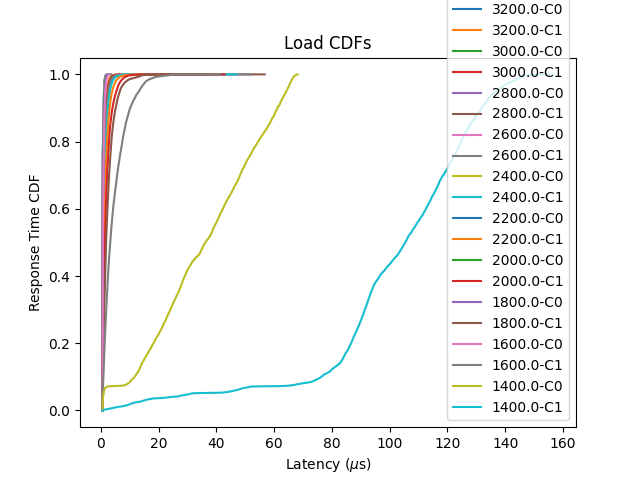

Num Requests @ mean_arrival_time 3200.0 cycles = 20000
Num Requests @ mean_arrival_time 3000.0 cycles = 20000
Num Requests @ mean_arrival_time 2800.0 cycles = 20000
Num Requests @ mean_arrival_time 2600.0 cycles = 20000
Num Requests @ mean_arrival_time 2400.0 cycles = 20000
Num Requests @ mean_arrival_time 2200.0 cycles = 20000
Num Requests @ mean_arrival_time 2000.0 cycles = 20000
Num Requests @ mean_arrival_time 1800.0 cycles = 20000
Num Requests @ mean_arrival_time 1600.0 cycles = 20000
Num Requests @ mean_arrival_time 1400.0 cycles = 17553


In [12]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_sched(lnic_sched_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


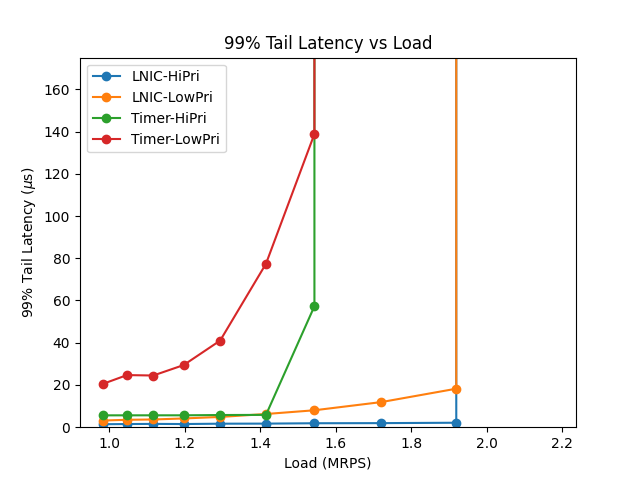

In [13]:
# Plot tail latency vs load
plt.figure()
lnic_sched_tail_c0.plot(marker='o', label='LNIC-HiPri')
lnic_sched_tail_c1.plot(marker='o', label='LNIC-LowPri')
timer_sched_tail_c0.plot(marker='o', label='Timer-HiPri')
timer_sched_tail_c1.plot(marker='o', label='Timer-LowPri')
plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 175])
plt.show()

In [14]:
lnic_sched_tail_c0
# lnic_sched_tail_c1
# timer_sched_tail_c0
# timer_sched_tail_c1

load
0.981954     1.407150e+00
1.046743     1.494238e+00
1.116528     1.564641e+00
1.196994     1.495775e+00
1.293689     1.659887e+00
1.415184     1.695938e+00
1.543584     1.869959e+00
1.720741     1.925906e+00
1.919577     2.111672e+00
2.177177    1.000000e+100
Name: resp_time, dtype: float64

#### Notes:
* If the NIC was smarter about allocating buffer space for each context then the high priority (Context 0) thread would probably be able to achieve higher throughput for the LNIC-driven approach. Right now, msgs are dropped for both contexts when queues fill up. Really, only the C1 queue is filling up so only those msgs should be dropped.
* A pretty easy fix for this would be to only allow each context to use a max number of buffers in the reassembly module.

# Bounded Processing Time

In [15]:
# resdir = 'results-workload/2020-08-07--23-41-53-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--01-42-09-lnic-evaluation/switch0' # fine-grained
# resdir = 'results-workload/2020-08-09--20-05-50-lnic-evaluation/switch0' # fixed request rate
resdir = 'nanoPU-results/scheduling/bounded/load-sweep'
bounded_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
bounded_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
bounded_tail_c0, bounded_tail_c1 = process_resp_time_sched(bounded_stats, bounded_req_stats)

In [16]:
# resdir = 'results-workload/2020-08-07--23-50-45-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--01-33-54-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/scheduling/unbounded/load-sweep'
unbounded_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
unbounded_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
unbounded_tail_c0, unbounded_tail_c1 = process_resp_time_sched(unbounded_stats, unbounded_req_stats)

<IPython.core.display.Javascript object>


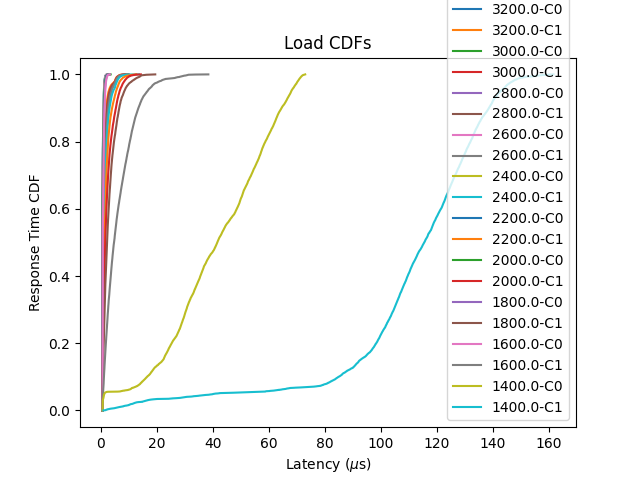

Num Requests @ mean_arrival_time 3200.0 cycles = 20000
Num Requests @ mean_arrival_time 3000.0 cycles = 20000
Num Requests @ mean_arrival_time 2800.0 cycles = 20000
Num Requests @ mean_arrival_time 2600.0 cycles = 20000
Num Requests @ mean_arrival_time 2400.0 cycles = 20000
Num Requests @ mean_arrival_time 2200.0 cycles = 20000
Num Requests @ mean_arrival_time 2000.0 cycles = 20000
Num Requests @ mean_arrival_time 1800.0 cycles = 20000
Num Requests @ mean_arrival_time 1600.0 cycles = 20000
Num Requests @ mean_arrival_time 1400.0 cycles = 16805


In [17]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_sched(bounded_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


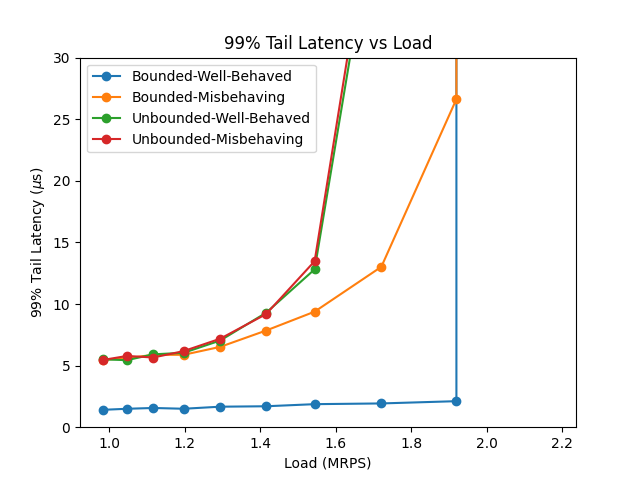

In [18]:
# Plot tail latency vs load
plt.figure()
bounded_tail_c0.plot(marker='o', label='Bounded-Well-Behaved')
bounded_tail_c1.plot(marker='o', label='Bounded-Misbehaving')
unbounded_tail_c0.plot(marker='o', label='Unbounded-Well-Behaved')
unbounded_tail_c1.plot(marker='o', label='Unbounded-Misbehaving')
plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 30])
plt.show()

# Load Balancing

In [19]:
def plot_load_cdfs_lb(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data, 'resp_time', label='{}'.format(m))
        print('Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data)))

In [20]:
# If the number of responses is less than the number of
# requests that were sent then need to pad the data with
# infinite response times.
def pad_resp_df_lb(resp_df, req_df):
    for m in req_df['mean_arrival_time'].unique():
        # extract all data for this load
        req_load_df = req_df[req_df['mean_arrival_time'] == m]
        resp_load_df = resp_df[resp_df['mean_arrival_time'] == m]
        # add dummy rows with infinite resp time if needed
        if len(resp_load_df) < len(req_load_df):
            #print "mean:", m, ", missing", len(req_load_df) - len(resp_load_df), "requests (", 100*(len(req_load_df) - len(resp_load_df))/len(req_load_df), "% of total", len(req_load_df), ")"
            dummy_row = resp_load_df.head(1).copy()
            dummy_row['resp_time'] = 1e100
            dummy_rows = pd.concat([dummy_row]*(len(req_load_df) - len(resp_load_df)), ignore_index=True)
            resp_df = pd.concat([resp_df, dummy_rows], ignore_index=True)
        elif len(resp_load_df) > len(req_load_df):
            print("WARNING: more responses ({}) received than requests sent ({})! m={}".format(len(resp_load_df), len(req_load_df), m))
    return resp_df

In [21]:
def process_resp_time_lb(resp_df, req_df):
    # compute load
    load_map = get_load_map(req_df)
    resp_df['load'] = resp_df[['mean_arrival_time']].applymap(lambda x: load_map[x])
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df_lb(resp_df, req_df)
    tail = resp_df.groupby('load')['resp_time'].quantile(0.99)
    return tail

In [22]:
# resdir = 'results-workload/2020-08-08--00-40-06-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--02-11-54-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/load-balance/rss/load-sweep'
rss_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
rss_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
rss_tail = process_resp_time_lb(rss_stats, rss_req_stats)

In [23]:
# resdir = 'results-workload/2020-08-08--00-44-00-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--02-17-40-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/load-balance/jbsq/load-sweep'
jbsq_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
jbsq_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
jbsq_tail = process_resp_time_lb(jbsq_stats, jbsq_req_stats)

In [24]:
# resdir = 'results-workload/2020-08-08--00-48-38-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--02-30-24-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/load-balance/jbsq-pre/load-sweep'
jbsq_pre_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
jbsq_pre_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
jbsq_pre_tail = process_resp_time_lb(jbsq_pre_stats, jbsq_pre_req_stats)

<IPython.core.display.Javascript object>


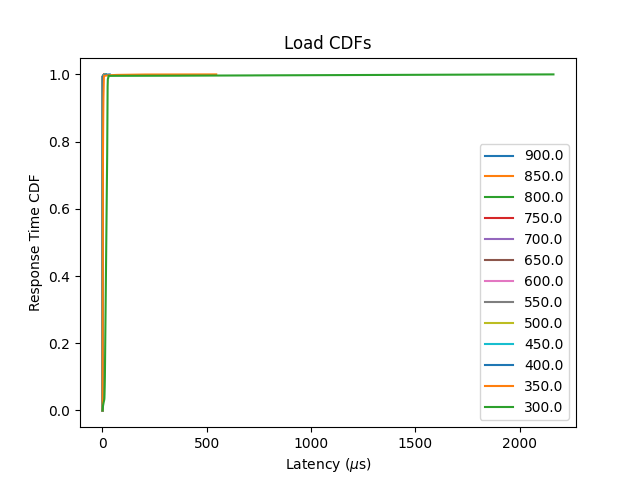

Num Requests @ mean_arrival_time 900.0 cycles = 20000
Num Requests @ mean_arrival_time 850.0 cycles = 20000
Num Requests @ mean_arrival_time 800.0 cycles = 20000
Num Requests @ mean_arrival_time 750.0 cycles = 20000
Num Requests @ mean_arrival_time 700.0 cycles = 20000
Num Requests @ mean_arrival_time 650.0 cycles = 20000
Num Requests @ mean_arrival_time 600.0 cycles = 20000
Num Requests @ mean_arrival_time 550.0 cycles = 20000
Num Requests @ mean_arrival_time 500.0 cycles = 20000
Num Requests @ mean_arrival_time 450.0 cycles = 20000
Num Requests @ mean_arrival_time 400.0 cycles = 20000
Num Requests @ mean_arrival_time 350.0 cycles = 20000
Num Requests @ mean_arrival_time 300.0 cycles = 18552


In [25]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_lb(jbsq_pre_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


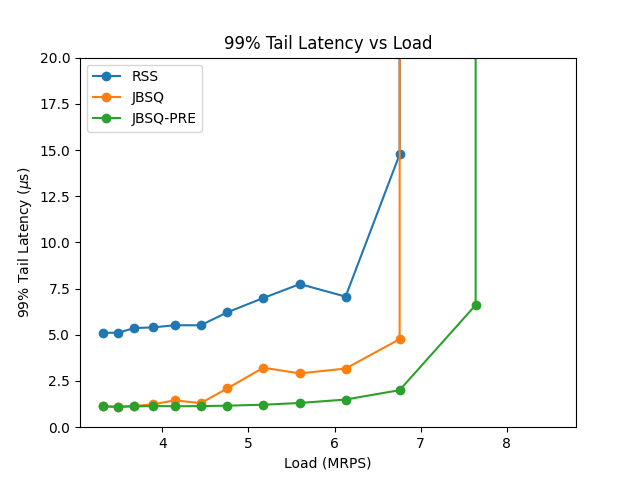

In [26]:
# Plot tail latency vs load
plt.figure()
rss_tail.plot(marker='o', label='RSS')
jbsq_tail.plot(marker='o', label='JBSQ')
jbsq_pre_tail.plot(marker='o', label='JBSQ-PRE')
plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 20])
plt.show()

# Incast

In [27]:
def process_qsize_stats(df):
    start_time = df[df['port'] == 0].index[1]
    df.index = (df.index - start_time)/3.2e3 # convert to us
    df['lp_bytes'] /= 1e3 # convert to KB
    df['hp_bytes'] /= 1e3 # convert to KB

In [28]:
resdir = 'nanoPU-results/incast/90host/ndp'
ndp_stats = pd.read_csv(os.path.join(resdir, 'qsize.csv'), index_col='time')
process_qsize_stats(ndp_stats)

In [29]:
resdir = 'nanoPU-results/incast/90host/no-ndp'
no_ndp_stats = pd.read_csv(os.path.join(resdir, 'qsize.csv'), index_col='time')
process_qsize_stats(no_ndp_stats)

<IPython.core.display.Javascript object>


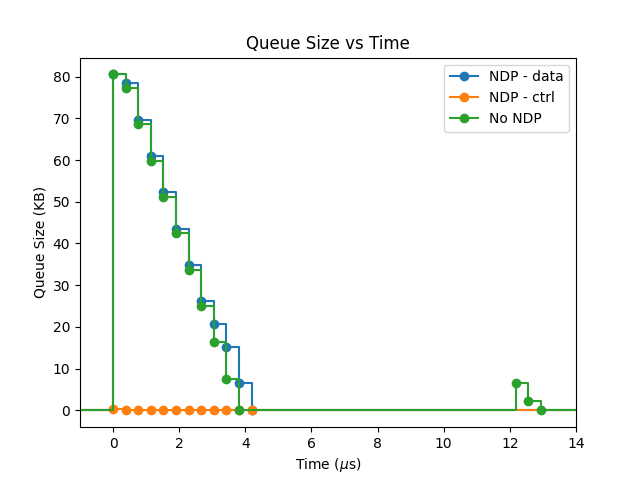

In [30]:
plt.figure()
ndp_stats[ndp_stats['port'] == 0]['lp_bytes'].plot(drawstyle="steps-post", marker='o', label='NDP - data')
ndp_stats[ndp_stats['port'] == 0]['hp_bytes'].plot(drawstyle="steps-post", marker='o', label='NDP - ctrl')
no_ndp_stats[no_ndp_stats['port'] == 0]['lp_bytes'].plot(drawstyle="steps-post", marker='o', label='No NDP')
plt.title('Queue Size vs Time')
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Queue Size (KB)')
plt.legend(loc='upper right')
plt.xlim([-1, 14])
plt.show()

# MICA

In [31]:
def get_zero_load_stats(resp_df, time_type='resp_time'):
    min_load = max(resp_df['mean_arrival_time'].unique())
    min_load_resp_df = resp_df[resp_df['mean_arrival_time'] == min_load]
    mean_arrival_time = min_load_resp_df['sent_time'].diff().mean()
    mrps = 1e3/(mean_arrival_time/3.2)
    return dict(mean_lat=min_load_resp_df[time_type].mean(),
                 p99_lat=min_load_resp_df[time_type].quantile(0.99),
                 mrps=1e3/(mean_arrival_time/3.2))
    #print min(resp_df['mean_arrival_time'].unique())

## 500 items

One context: {'mean_lat': 0.694025390625, 'p99_lat': 0.9209406249999995, 'mrps': 0.8750851883332186}
Four contexts: {'mean_lat': 0.74890090625, 'p99_lat': 1.3371906249999994, 'mrps': 0.8750851883332186}


<IPython.core.display.Javascript object>


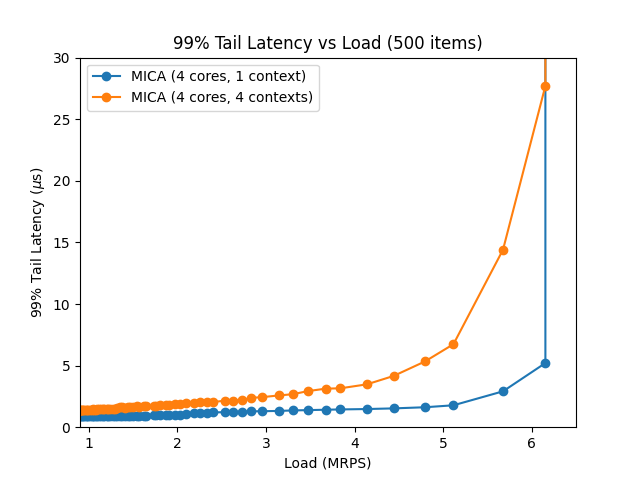

In [91]:
#resdir = 'results-workload/2020-08-18--14-32-48-lnic-multi-core-mica/switch0/' # 500 items, 1ctx
resdir = 'nanoPU-results/mica/500-items/one-context' # 500 items, 1ctx
mica_1ctx_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
mica_1ctx_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
mica_1ctx_tail = process_resp_time_lb(mica_1ctx_stats, mica_1ctx_req_stats)

#resdir = 'results-workload/2020-08-18--14-58-28-lnic-multi-core-mica/switch0/' # 500 items, 4ctx
resdir = 'nanoPU-results/mica/500-items/four-contexts' # 500 items, 4ctx
mica_4ctx_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
mica_4ctx_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
mica_4ctx_tail = process_resp_time_lb(mica_4ctx_stats, mica_4ctx_req_stats)

print ("One context:", get_zero_load_stats(mica_1ctx_stats))
print ("Four contexts:", get_zero_load_stats(mica_4ctx_stats))

# Plot tail latency vs load
plt.figure()
mica_1ctx_tail.plot(marker='o', label='MICA (4 cores, 1 context)')
mica_4ctx_tail.plot(marker='o', label='MICA (4 cores, 4 contexts)')
plt.title('99% Tail Latency vs Load (500 items)')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 30])
plt.xlim([0.9, 6.5])
plt.savefig('mica-latency-500-items.pdf')
plt.savefig('mica-latency-500-items.png')
plt.show()

## 10K items

One context: {'mean_lat': 0.8512485625000001, 'p99_lat': 1.1590625, 'mrps': 0.8995025502172409}
Four contexts: {'mean_lat': 0.9267794843750001, 'p99_lat': 1.775331249999997, 'mrps': 0.8995025502172409}


<IPython.core.display.Javascript object>


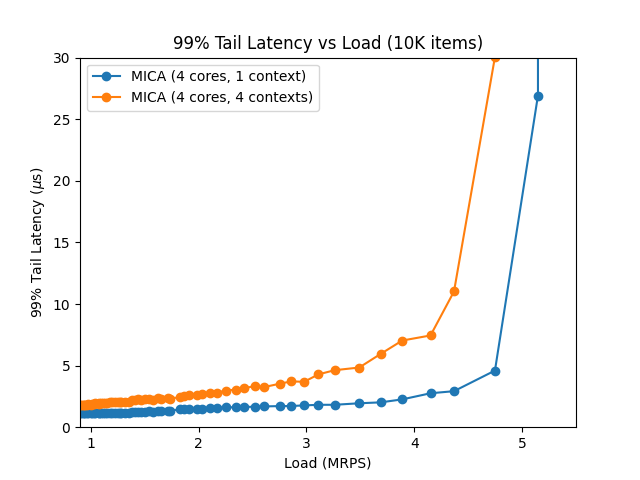

In [92]:
#resdir = 'results-workload/2020-08-14--04-31-17-lnic-multi-core-mica/switch0/' # 1K items
#resdir = 'nanoPU-results/mica/1k-items/one-context' # 1K items
#resdir = 'results-workload/2020-08-17--14-10-27-lnic-multi-core-mica/switch0/' # 10K items, 1ctx
resdir = 'nanoPU-results/mica/10k-items/one-context' # 10K items, 1ctx
mica_1ctx_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
mica_1ctx_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
mica_1ctx_tail = process_resp_time_lb(mica_1ctx_stats, mica_1ctx_req_stats)

#resdir = 'nanoPU-results/mica/1k-items/four-contexts' # 1K items
#resdir = 'results-workload/2020-08-17--04-51-46-lnic-multi-core-mica/switch0/' # 10K items
# resdir = 'results-workload/2020-08-17--15-16-14-lnic-multi-core-mica/' # 10K items
#resdir = 'results-workload/2020-08-17--16-33-16-lnic-multi-core-mica/' # 10K items, 4ctx
resdir = 'nanoPU-results/mica/10k-items/four-contexts' # 10K items, 4ctx
#resdir = 'results-workload/2020-08-18--04-02-34-lnic-multi-core-mica/switch0/' # 10K items
mica_4ctx_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
mica_4ctx_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
mica_4ctx_tail = process_resp_time_lb(mica_4ctx_stats, mica_4ctx_req_stats)

print ("One context:", get_zero_load_stats(mica_1ctx_stats))
print ("Four contexts:", get_zero_load_stats(mica_4ctx_stats))

# Plot tail latency vs load
plt.figure()
mica_1ctx_tail.plot(marker='o', label='MICA (4 cores, 1 context)')
mica_4ctx_tail.plot(marker='o', label='MICA (4 cores, 4 contexts)')
plt.title('99% Tail Latency vs Load (10K items)')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 30])
plt.xlim([0.9, 5.5])
plt.savefig('mica-latency-10k-items.pdf')
plt.savefig('mica-latency-10k-items.png')
plt.show()

In [93]:
mica_1ctx_tail_df = pd.DataFrame()
mica_1ctx_tail_df['Latency'] = pd.Series(mica_1ctx_tail)
mica_1ctx_tail_df['Run'] = 'Mica (4 cores, 1 context)'
mica_1ctx_tail_df['Load'] = mica_1ctx_tail_df.index

mica_4ctx_tail_df = pd.DataFrame()
mica_4ctx_tail_df['Latency'] = pd.Series(mica_4ctx_tail)
mica_4ctx_tail_df['Run'] = 'Mica (4 cores, 4 context)'
mica_4ctx_tail_df['Load'] = mica_4ctx_tail_df.index

mica_tail_df = pd.concat([mica_1ctx_tail_df, mica_4ctx_tail_df])
mica_tail_df

,Latency,Run,Load
load,,,
0.899495,1.159063e+00,"Mica (4 cores, 1 context)",0.899495
0.913004,1.142816e+00,"Mica (4 cores, 1 context)",0.913004
0.923327,1.144375e+00,"Mica (4 cores, 1 context)",0.923327
0.934578,1.138753e+00,"Mica (4 cores, 1 context)",0.934578
0.948224,1.142813e+00,"Mica (4 cores, 1 context)",0.948224
...,...,...,...
4.748312,3.004745e+01,"Mica (4 cores, 4 context)",4.748312
5.147284,1.000000e+100,"Mica (4 cores, 4 context)",5.147284
5.629973,1.000000e+100,"Mica (4 cores, 4 context)",5.629973


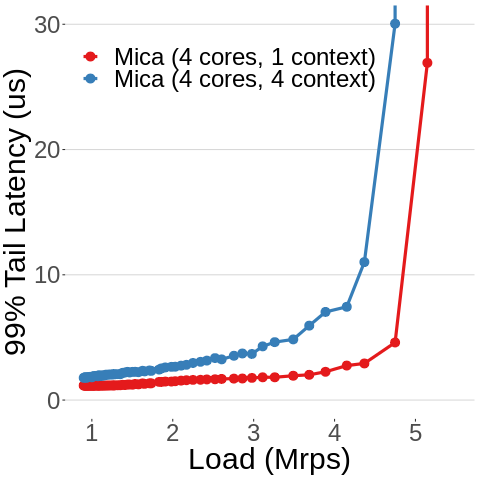

In [94]:
%%R -i mica_tail_df

ggplot(mica_tail_df, aes(y=Latency, x=Load, colour=Run)) + 
    geom_line(size=1.5) +
    geom_point(size=4) +
    coord_cartesian(xlim = c(0.9, 5.5), ylim = c(0, 30)) +
#     facet_grid(factor(Perc) ~ .) +
    labs(y = "99% Tail Latency (us)", x = "Load (Mrps)") +
    theme_hc(base_size = 30) +
    theme(legend.position = c(0.4, 0.868), legend.title = element_blank()) +
#     guides(col = guide_legend(nrow = 2, byrow = TRUE)) +
    scale_colour_brewer(palette = "Set1")

In [95]:
%%R -i mica_tail_df
ggsave("mica_tail_latency.pdf", width = 12, height = 5)

# Chain Replication

In [96]:
def process_resp_time_cr(resp_df, req_df):
    # compute load
    load_map = get_load_map(req_df)
    resp_df['load'] = resp_df[['mean_arrival_time']].applymap(lambda x: load_map[x])
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    #resp_df = pad_resp_df_lb(resp_df, req_df)
    tail = resp_df.groupby('load')['resp_time'].quantile(0.99)
    return tail

def process_resp_time_cr_proxy(resp_df, req_df):
    # compute load
    load_map = get_load_map(req_df)
    resp_df['load'] = resp_df[['mean_arrival_time']].applymap(lambda x: load_map[x])
    #print resp_df['mean_arrival_time'].unique()
    #print req_df['mean_arrival_time'].unique()
    # convert resp_time from cycles to us
    resp_df['service_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df_lb(resp_df, req_df)
    tail = resp_df.groupby('load')['service_time'].quantile(0.99)
    #tail = resp_df.groupby('load')['service_time'].mean()
    return tail

<IPython.core.display.Javascript object>


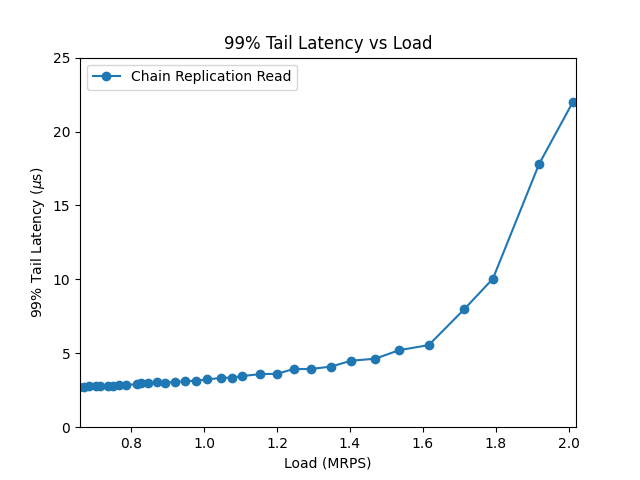

In [97]:
#resdir = 'results-workload/2020-08-14--09-22-44-lnic-multi-core-chain-rep/switch0/'
resdir = 'nanoPU-results/chainrep/write-3-replicas/'
chainrep_write_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
chainrep_write_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
chainrep_write_tail = process_resp_time_cr(chainrep_write_stats, chainrep_write_req_stats)

# Plot tail latency vs load
plt.figure()
chainrep_write_tail.plot(marker='o', label='Chain Replication Read')
plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 25])
plt.xlim([0.66, 2.02])
plt.savefig('/tmp/chainrep-eval.pdf')
plt.savefig('/tmp/chainrep-eval.png')
plt.show()

## Chain Replication with Proxy Client

WRITE: {'mean_lat': 0.7970395649944984, 'p99_lat': 1.6072093749999998, 'mrps': 0.7025339168163368}
READ: {'mean_lat': 2.37687600060036, 'p99_lat': 3.7053937500000003, 'mrps': 0.7023230828494036}


<IPython.core.display.Javascript object>


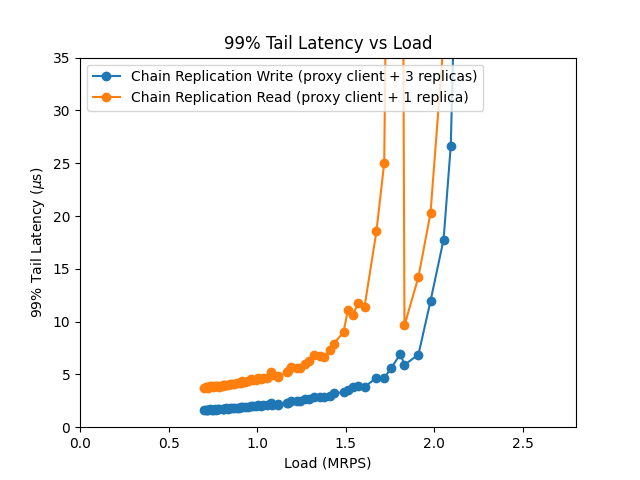

In [98]:
#resdir = 'results-workload/2020-08-15--15-08-11-lnic-multi-core-chain-rep/switch0' # 1K items
#resdir = 'nanoPU-results/chainrep/proxy-client/1k-items/write-3-replicas' # 1K items
# resdir = 'results-workload/2020-08-18--07-19-16-lnic-multi-core-chain-rep/switch0/' # 10K items
resdir = 'nanoPU-results/chainrep/proxy-client/10k-items/read-1-replica/' # 10K items
chainrep_write_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
chainrep_write_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
chainrep_write_tail = process_resp_time_cr_proxy(chainrep_write_stats, chainrep_write_req_stats)

#resdir = 'results-workload/2020-08-16--12-43-35-lnic-multi-core-chain-rep/switch0' # 1K items
# resdir = 'nanoPU-results/chainrep/proxy-client/1k-items/read-1-replica' # 1K items
#resdir = 'results-workload/2020-08-18--08-34-48-lnic-multi-core-chain-rep/switch0/' # 10K items
resdir = 'nanoPU-results/chainrep/proxy-client/10k-items/write-3-replicas/' # 10K items
chainrep_read_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
chainrep_read_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
chainrep_read_tail = process_resp_time_cr_proxy(chainrep_read_stats, chainrep_read_req_stats)

print("WRITE:", get_zero_load_stats(chainrep_write_stats, time_type='service_time'))
print("READ:", get_zero_load_stats(chainrep_read_stats, time_type='service_time'))

# Plot tail latency vs load
plt.figure()
chainrep_write_tail.plot(marker='o', label='Chain Replication Write (proxy client + 3 replicas)')
chainrep_read_tail.plot(marker='o', label='Chain Replication Read (proxy client + 1 replica)')
plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 35])
plt.xlim([0.0, 2.8])
plt.savefig('/tmp/chainrep-eval.pdf')
plt.savefig('/tmp/chainrep-eval.png')
plt.show()